Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 

Model 1 ABOD
Model 2 LOF
Model 3 iForest
Model 4 Autoencoder
Model 5 LUNAR

(200, 2)
1 fitting ABOD
(200,) (200,)

(200, 2)
1 fitting ABOD
(200,) (200,)

(200, 2)
1 fitting ABOD
(200,) (200,)

(200, 2)
1 fitting ABOD
(200,) (200,)

(200, 2)
2 fitting LOF
(200,) (200,)

(200, 2)
2 fitting LOF
(200,) (200,)

(200, 2)
2 fitting LOF
(200,) (200,)

(200, 2)
2 fitting LOF
(200,) (200,)

(200, 2)
3 fitting iForest
(200,) (200,)

(200, 2)
3 fitting iForest
(200,) (200,)

(200, 2)
3 fi

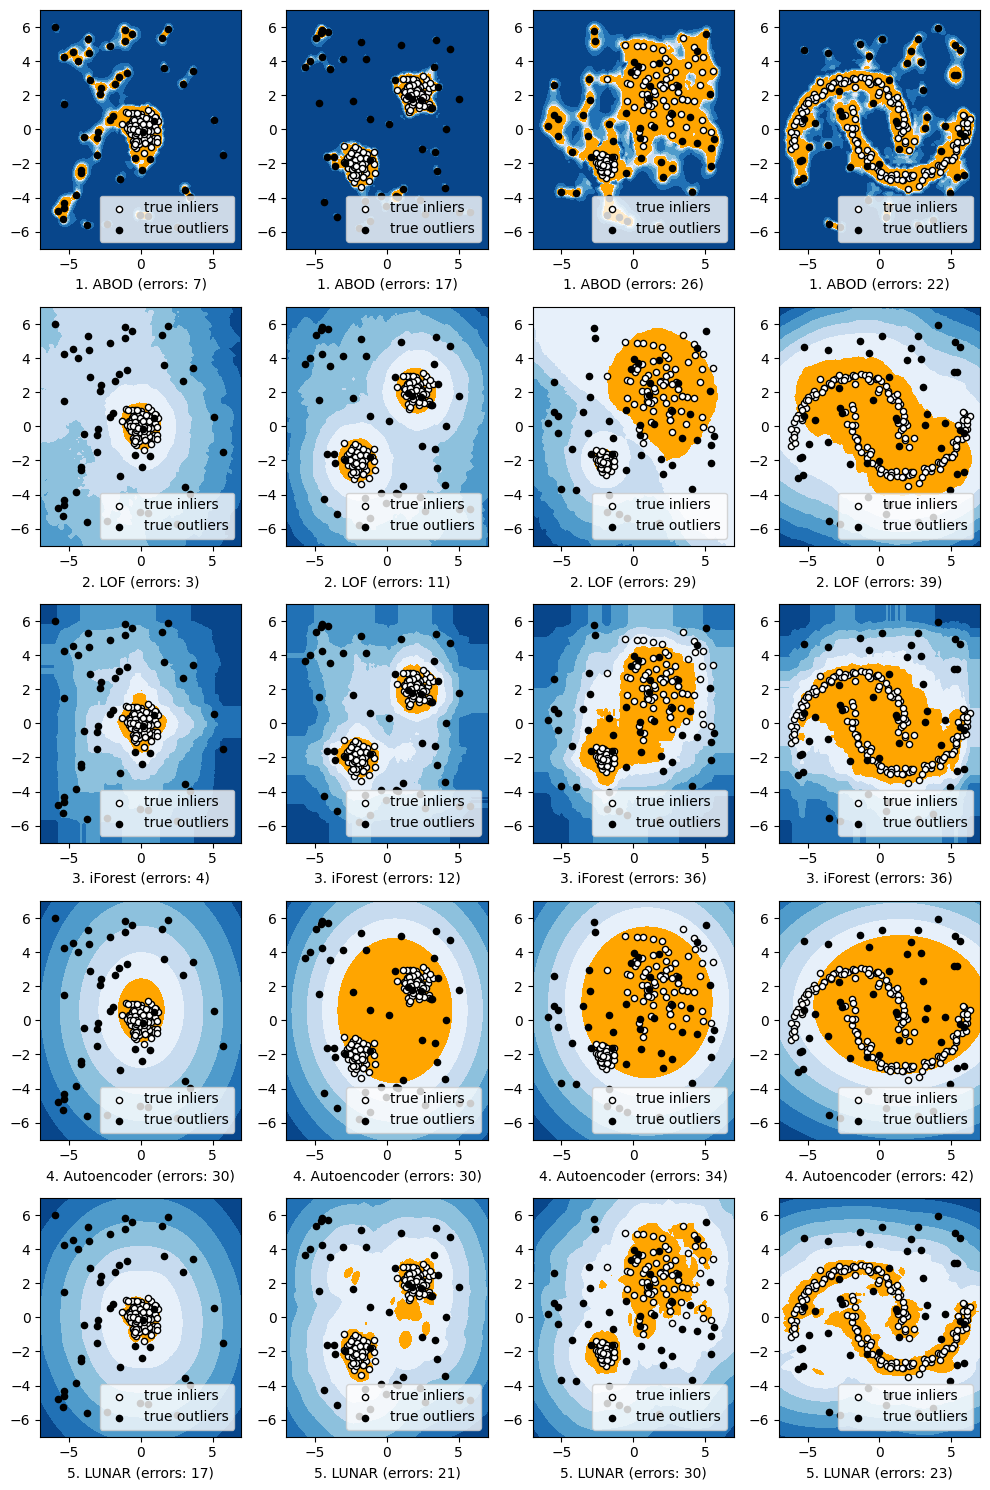

In [9]:
# -*- coding: utf-8 -*-
"""Compare all detection algorithms by plotting decision boundaries and
the number of decision boundaries.
"""
# Author: Yue Zhao <zhaoy@cmu.edu>
# License: BSD 2 clause

from __future__ import division
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.lunar import LUNAR
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
import matplotlib.font_manager
import matplotlib.pyplot as plt
from numpy import percentile
import numpy as np
import warnings
from __future__ import print_function
from sklearn.datasets import make_blobs, make_moons

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

# supress warnings for clean output

warnings.filterwarnings("ignore")

# Import all models

# TODO: add neural networks, LOCI, SOS, COF, SOD

# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]],
               cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]],
               cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_inliers, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
]
for i in range(len(datasets)):
    datasets[i] = np.concatenate([datasets[i], np.random.uniform(
        low=-6, high=6, size=(n_outliers, 2))], axis=0)


# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print(
    'Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(
        shape=ground_truth.shape))
print(ground_truth, '\n')

random_state = 42
# Define nine outlier detection tools to be compared
classifiers = {
    'ABOD':
    ABOD(contamination=outliers_fraction),

        'LOF':
    LOF(n_neighbors=35, contamination=outliers_fraction),

        'iForest': IForest(contamination=outliers_fraction,
                           random_state=random_state),

    'Autoencoder': AutoEncoder(hidden_neurons=[5, 1, 5]),
        'LUNAR': LUNAR(),


}

# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

# Fit the models with the generated data and
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    # X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    # X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    # X = np.r_[X1, X2]
    # # Add outliers
    # X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(10, 15))
    num = 1
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        for dataset in datasets:
            X = dataset
            inliers = X[:n_inliers]
            outliers = X[n_inliers:]
            print()
            print(X.shape)
            print(i + 1, 'fitting', clf_name)
            # fit the data and tag outliers
            if clf_name in ['AutoEncoder', 'LUNAR']:
                clf.fit(inliers)
            else:
                clf.fit(X)
            scores_pred = clf.decision_function(X) * -1
            y_pred = clf.predict(X)
            threshold = percentile(scores_pred, 100 * outliers_fraction)
            print(ground_truth.shape, y_pred.shape)
            n_errors = (y_pred.astype(np.int32) !=
                        ground_truth.astype(np.int32)).astype(np.int32).sum()
            # plot the levels lines and the points

            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
            Z = Z.reshape(xx.shape)
            subplot = plt.subplot(5, 4, num)
            subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                             cmap=plt.cm.Blues_r)
            # a = subplot.contour(xx, yy, Z, levels=[threshold],
            #                     linewidths=2, colors='red')
            subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                             colors='orange')
            b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                                s=20, edgecolor='k')
            c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                                s=20, edgecolor='k')
            subplot.axis('tight')
            subplot.legend(
                [
                    # a.collections[0],
                    b, c],
                [
                    # 'learned decision function',
                    'true inliers', 'true outliers'],
                prop=matplotlib.font_manager.FontProperties(size=10),
                loc='lower right')
            subplot.set_xlabel("%d. %s (errors: %d)" %
                               (i + 1, clf_name, n_errors))
            subplot.set_xlim((-7, 7))
            subplot.set_ylim((-7, 7))
            num += 1
    plt.tight_layout()

plt.savefig('ALL.png', dpi=300, bbox_inches='tight')
plt.show()